<hr>

# AI Workflow Capstone - AAVAIL - **Part 2**

Student: `Alexey Tyurin`<br>
Date: `1/17/2024`
<hr>

### Introduction
This case study focuses on data transformations and models in time-series forecasting. Time-series data, prevalent in finance, signal processing, and weather forecasting, involves predicting future values based on past observations. This study will guide you through applying supervised learning techniques to such data, encouraging exploration of time-series modeling tools. The objective is to forecast metrics like purchases, views, or revenue, closely tied to business opportunities.

### Time-series analysis
In our time-series analysis, we primarily use TensorFlow, scikit-learn, and Spark ML for model implementation. This approach is vital for predicting future business metrics like monthly revenue. For such predictions, feature engineering is key. We can create features from past revenue data (e.g., previous day, week, month, three months) to help models like random forests or boosting algorithms identify data patterns. This feature engineering is often tailored to each specific case.

Although our current goal is to predict the next point in a time-series, considering future projections, such as three months ahead, can be beneficial. This can be done using recursive forecasting, where predictions are iteratively added to the feature matrix, or ensemble forecasting, which uses separate models for each forecast. A combination of these methods can also be effective.

It's important to note that linear regression assumptions may not hold in time-series due to auto-correlation, especially when features are mainly revenue-based and highly correlated. More sophisticated models, combined with well-crafted features, are generally more effective in this context.

### Deliverables for Data Engineering in Time-Series Forecasting:

**Feature Engineering with Rolling Window**:
- Utilize historical data, as future values (unrealized) are unknown.
Generate additional features based on historical values for each data point. This involves creating a rolling window of past data (e.g., daily, weekly, monthly) to capture trends and patterns in the historical revenue data.


**Target Value with Rolling Window**:
- Standardize the target across models to be the sum of revenues over the next 30 days for any given point in time.
In supervised learning, this target is represented as a single number, encapsulating the total forecasted revenue for the forthcoming thirty days. This approach ensures consistency and comparability across different models and forecasting techniques.

### Tasks
1. State the different modeling approaches that you will compare to address the business opportunity.
2. Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.
3. Re-train your model on all of the data using the selected approach and prepare it for deployment.
4. Articulate your findings in a summary report.

**HINT:** *To standardize the approach across models ensure that your model predicts the next 30 days for any given point in time. For supervised learning, the total revenue over the next thirty days can be represented as a single number.*

### 1. State the different modeling approaches that you will compare to address the business opportunity.

In [6]:
# Libraries

import os
#import re
import time
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from cslib import fetch_data

DEV=True

In [7]:
# CONSTANTS

IMAGE_DIR = os.path.join(".", "images")
DATA_TRAIN_DIR = os.path.join(".", "cs-train")
DATA_PROD_DIR = os.path.join(".", "cs-production")

In [16]:
df = fetch_data(DATA_TRAIN_DIR)

In [17]:
# Creating a Summary DataFrame

ds = df.groupby(['country', 'invoice_date']).agg(
    purchases=('invoice', 'size'),
    unique_invoices=('invoice', 'nunique'),
    unique_streams=('stream_id', 'nunique'),
    total_views=('times_viewed', 'sum'),
    revenue=('price', 'sum')
).reset_index()

top = df.groupby('country')['price'].sum().nlargest(10).index.tolist()
ds = ds[ds['country'].isin(top)]

totals = ds.drop(['country'], axis=1).groupby('invoice_date').sum().reset_index()
totals['country'] = 'Total'
totals = totals[ds.columns]
ds = pd.concat([ds, totals])

ds.sample(6)

,country,invoice_date,purchases,unique_invoices,unique_streams,total_views,revenue
308,Total,2018-12-09,1403,50,767,5052,3874.27
1629,Norway,2019-06-18,90,1,90,570,473.36
20,Total,2017-12-20,540,32,395,3028,2268.31
446,Total,2019-06-05,2262,110,1095,11752,10507.89
619,EIRE,2019-05-29,1,1,1,1,7.50
645,EIRE,2019-07-23,10,2,10,85,73.02


### 2. Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.

### 3. Re-train your model on all of the data using the selected approach and prepare it for deployment.

### 4. Articulate your findings in a summary report.

In [1]:
import numpy as np
import pandas as pd
#from IPython.display import Image
import matplotlib.pyplot as plt

from cslib import fetch_data, engineer_features, convert_to_ts, fetch_ts

In [3]:
ts = convert_to_ts(fetch_data("cs-train/"))

In [4]:
ts.head()

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
0,2017-11-01,0,0,0,0,2017-11,0.0
1,2017-11-02,0,0,0,0,2017-11,0.0
2,2017-11-03,0,0,0,0,2017-11,0.0
3,2017-11-04,0,0,0,0,2017-11,0.0
4,2017-11-05,0,0,0,0,2017-11,0.0


In [5]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype        
---  ------           --------------  -----        
 0   date             607 non-null    datetime64[s]
 1   purchases        607 non-null    int32        
 2   unique_invoices  607 non-null    int64        
 3   unique_streams   607 non-null    int64        
 4   total_views      607 non-null    int64        
 5   year_month       607 non-null    object       
 6   revenue          607 non-null    float64      
dtypes: datetime64[s](1), float64(1), int32(1), int64(3), object(1)
memory usage: 30.9+ KB


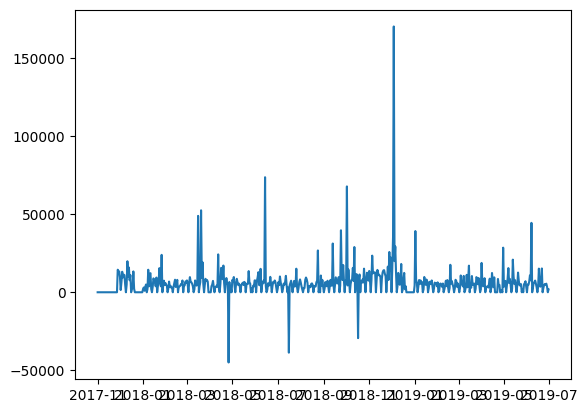

In [6]:
#the columns in the dfts are: date, purchases, unique_invoices, unique_streams, total_views, year_month, revenue
#plot
plt.plot(ts['date'], ts['revenue'])
plt.show()



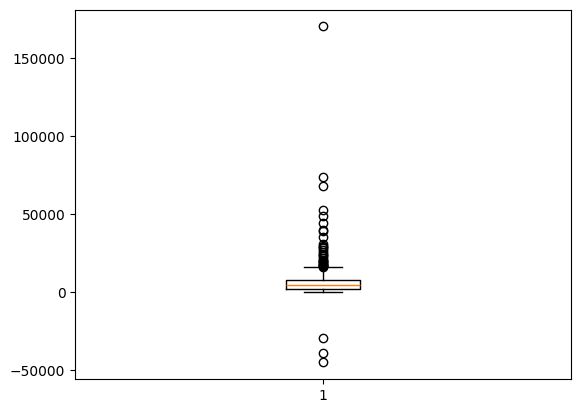

In [7]:
#show outliers
plt.boxplot(ts['revenue'])
plt.show()

In [8]:
#export to csv
ts.to_csv('ts-data.csv', index=False)

[EOF]